In [1]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import gc
import statsmodels.stats.proportion

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from legacy_model import *

In [2]:
# Get raw data
raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")

# Get feature data
feature_df = preprocess_raw_data(raw_data, include_direction=True)

/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
# Output some diagnostics on features
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(249793, 82)
(249793, 1725)


In [4]:
# Output basic quantities for sample
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts()))
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts(normalize=True)))

    justice_outcome_disposition
 0                       114780
 1                        94505
-1                        40508
    justice_outcome_disposition
 0                     0.459500
 1                     0.378333
-1                     0.162166


In [6]:
# Setup training time period
dummy_window_terms = 10
min_training_years = 30
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max()+1)

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 6

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Number of years between "forest fires"
reset_interval = 9999

# Setup model
m = None
term_count = 0

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    dummy_train_index = (raw_data.loc[:, "term"].isin(range(term-dummy_window_terms, term))).values
    test_index = (raw_data.loc[:, "term"] == term).values
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    dummy_target_data_train = raw_data.loc[dummy_train_index, "justice_outcome_disposition"].astype(int).values
    target_data_train = raw_data.loc[train_index, "justice_outcome_disposition"].astype(int).values

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = raw_data.loc[test_index, "justice_outcome_disposition"].astype(int).values
    
    # Check if we should rebuild the model based on changing natural court
    if term_count % reset_interval == 0:
        # "Forest fire;" grow a new forest from scratch
        print("Reset interval hit; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        m = None
    else:
        # Check if the justice set has changed
        if set(raw_data.loc[raw_data.loc[:, "term"] == (term-1), "justice"].unique()) != \
            set(raw_data.loc[raw_data.loc[:, "term"] == (term), "justice"].unique()):
            # natural Court change; trigger forest fire
            print("Natural court change; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
            m = None
                                              
    # Build or grow a model depending on initial/reset condition
    if not m:
        # Grow an initial forest
        m = sklearn.ensemble.RandomForestClassifier(n_estimators=initial_trees + (term_count * trees_per_term), 
                                                    #class_weight="balanced_subsample",
                                                    warm_start=True,
                                                    n_jobs=-1,
                                                   class_weight = 'auto')
    else:
        # Grow the forest by increasing the number of trees (requires warm_start=True)
        m.set_params(n_estimators=initial_trees + (term_count * trees_per_term))

    # Fit the forest model
    m.fit(feature_data_train,
          target_data_train)

    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_df.loc[dummy_train_index, :], dummy_target_data_train)
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = m.predict(feature_data_test)
    
    # Store scores per class
    scores = m.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)
    
    #  Clear
    del feature_data_train
    del feature_data_test
    del target_data_train
    del target_data_test
    gc.collect()

Term: 1821


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1822


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1823


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1824
Natural court change; rebuilding with 204 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1825


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1826
Natural court change; rebuilding with 216 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1827
Natural court change; rebuilding with 222 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1828


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1829
Natural court change; rebuilding with 234 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1830
Natural court change; rebuilding with 240 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1831


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1832


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1833


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1834


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1835
Natural court change; rebuilding with 270 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1836
Natural court change; rebuilding with 276 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1837
Natural court change; rebuilding with 282 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1838
Natural court change; rebuilding with 288 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1839


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1840


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1841


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1842
Natural court change; rebuilding with 312 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1843


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1844
Natural court change; rebuilding with 324 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1845
Natural court change; rebuilding with 330 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1846
Natural court change; rebuilding with 336 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1847
Natural court change; rebuilding with 342 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1848


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1849


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1850


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1851
Natural court change; rebuilding with 366 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1852
Natural court change; rebuilding with 372 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1853
Natural court change; rebuilding with 378 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1854


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1855


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1856


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1857
Natural court change; rebuilding with 402 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1858


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1859


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1860
Natural court change; rebuilding with 420 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1861
Natural court change; rebuilding with 426 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1862
Natural court change; rebuilding with 432 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1863
Natural court change; rebuilding with 438 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1864
Natural court change; rebuilding with 444 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1865


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1866
Natural court change; rebuilding with 456 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1867
Natural court change; rebuilding with 462 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1868
Natural court change; rebuilding with 468 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1869


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1870
Natural court change; rebuilding with 480 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1871
Natural court change; rebuilding with 486 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1872


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1873
Natural court change; rebuilding with 498 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1874


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1875


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1876
Natural court change; rebuilding with 516 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1877
Natural court change; rebuilding with 522 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1878


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1879


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1880
Natural court change; rebuilding with 540 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1881
Natural court change; rebuilding with 546 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1882
Natural court change; rebuilding with 552 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1883


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1884


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1885


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1886


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1887
Natural court change; rebuilding with 582 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1888
Natural court change; rebuilding with 588 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1889
Natural court change; rebuilding with 594 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1890
Natural court change; rebuilding with 600 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1891
Natural court change; rebuilding with 606 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1892
Natural court change; rebuilding with 612 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1893
Natural court change; rebuilding with 618 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1894
Natural court change; rebuilding with 624 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1895
Natural court change; rebuilding with 630 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1896
Natural court change; rebuilding with 636 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1897
Natural court change; rebuilding with 642 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1898
Natural court change; rebuilding with 648 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1899
Natural court change; rebuilding with 654 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1900
Natural court change; rebuilding with 660 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1901


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1902
Natural court change; rebuilding with 672 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1903
Natural court change; rebuilding with 678 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1904


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1905


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1906
Natural court change; rebuilding with 696 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1907


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1908
Natural court change; rebuilding with 708 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1909
Natural court change; rebuilding with 714 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1910
Natural court change; rebuilding with 720 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1911
Natural court change; rebuilding with 726 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1912
Natural court change; rebuilding with 732 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1913


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1914
Natural court change; rebuilding with 744 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1915
Natural court change; rebuilding with 750 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1916
Natural court change; rebuilding with 756 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1917


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1918


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1919


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1920
Natural court change; rebuilding with 780 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1921
Natural court change; rebuilding with 786 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1922
Natural court change; rebuilding with 792 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1923
Natural court change; rebuilding with 798 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1924
Natural court change; rebuilding with 804 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1925
Natural court change; rebuilding with 810 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1926


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1927


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1928


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1929
Natural court change; rebuilding with 834 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1930
Natural court change; rebuilding with 840 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1931
Natural court change; rebuilding with 846 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1932
Natural court change; rebuilding with 852 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1933


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1934


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1935


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1936


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1937
Natural court change; rebuilding with 882 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1938
Natural court change; rebuilding with 888 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1939
Natural court change; rebuilding with 894 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1940
Natural court change; rebuilding with 900 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1941
Natural court change; rebuilding with 906 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1942
Natural court change; rebuilding with 912 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1943
Natural court change; rebuilding with 918 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1944


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1945
Natural court change; rebuilding with 930 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1946
Natural court change; rebuilding with 936 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1947


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1948


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1949
Natural court change; rebuilding with 954 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1950


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1951


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1952


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1953
Natural court change; rebuilding with 978 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1954
Natural court change; rebuilding with 984 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1955


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1956
Natural court change; rebuilding with 996 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1957
Natural court change; rebuilding with 1002 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1958
Natural court change; rebuilding with 1008 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1959
Natural court change; rebuilding with 1014 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1960


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1961
Natural court change; rebuilding with 1026 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1962
Natural court change; rebuilding with 1032 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1963


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1964


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1965
Natural court change; rebuilding with 1050 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1966


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1967
Natural court change; rebuilding with 1062 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1968


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1969
Natural court change; rebuilding with 1074 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1970


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1971
Natural court change; rebuilding with 1086 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1972


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1973


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1974


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1975
Natural court change; rebuilding with 1110 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1976
Natural court change; rebuilding with 1116 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1977


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1978


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1979


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1980


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1981
Natural court change; rebuilding with 1146 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1982


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1983


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1984


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1985


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1986
Natural court change; rebuilding with 1176 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1987
Natural court change; rebuilding with 1182 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1988


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1989


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1990
Natural court change; rebuilding with 1200 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1991
Natural court change; rebuilding with 1206 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1992


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1993
Natural court change; rebuilding with 1218 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1994
Natural court change; rebuilding with 1224 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1995


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1996


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1997


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1998


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 1999


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2000


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2001


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2002


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2003


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2004


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2005
Natural court change; rebuilding with 1290 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2006
Natural court change; rebuilding with 1296 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2007


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2008


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2009
Natural court change; rebuilding with 1314 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2010
Natural court change; rebuilding with 1320 trees


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2011


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2012


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2013


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


Term: 2014


/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/ensemble/forest.py:452: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


In [7]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = raw_data.loc[evaluation_index, "justice_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"]
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.81      0.61      0.70     39251
          0       0.61      0.76      0.68    113074
          1       0.63      0.51      0.56     93176

avg / total       0.65      0.64      0.64    245501

[[23929 10894  4428]
 [ 3521 86060 23493]
 [ 2034 43525 47617]]
0.641977018424

Dummy model
             precision    recall  f1-score   support

         -1       0.33      0.01      0.02     39251
          0       0.52      0.77      0.62    113074
          1       0.57      0.46      0.51     93176

avg / total       0.51      0.53      0.48    245501

[[  495 31642  7114]
 [  618 86510 25946]
 [  398 49495 43283]]
0.530702522597



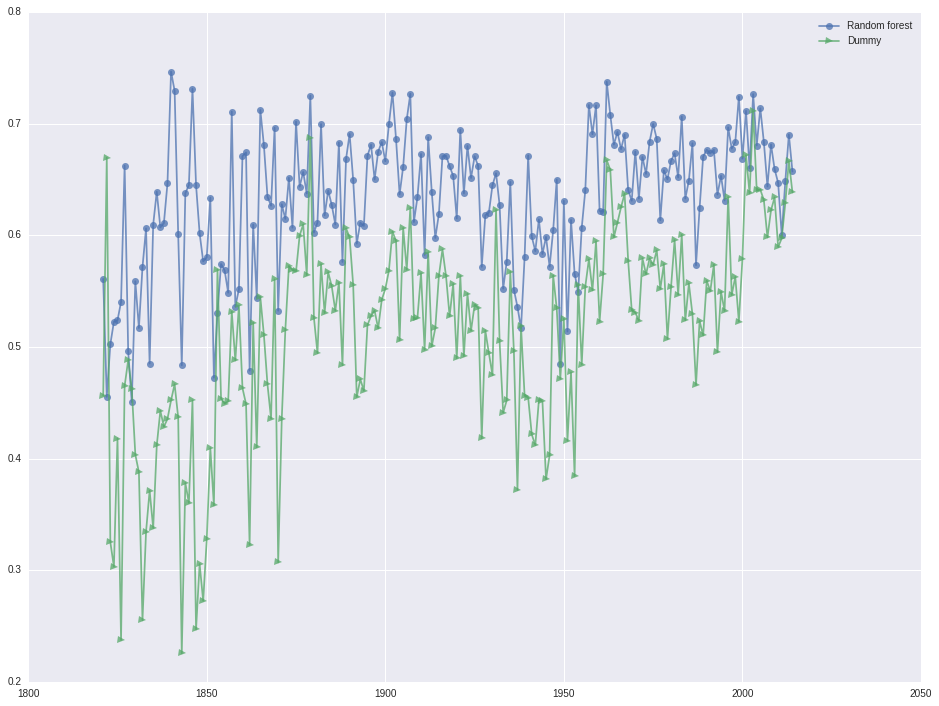

In [8]:
# Setup time series
rf_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_ts.index, rf_correct_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_ts.index, dummy_correct_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

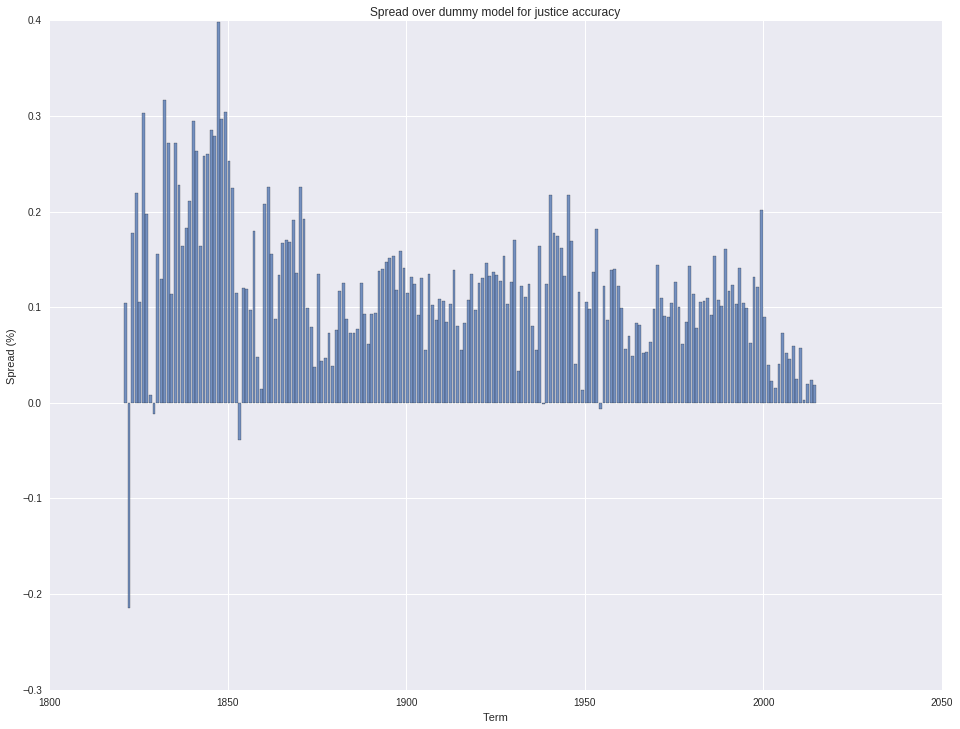

In [9]:
# Setup time series
rf_spread_ts = rf_correct_ts - dummy_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for justice accuracy")

In [10]:
# Feature importance
feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.feature_importances_)),
                                         columns=["feature", "importance"])
feature_importance_df.sort_values(["importance"], ascending=False).head(10)

,feature,importance
1723,justice_previous_lc_direction_diff,0.032429
1724,justice_cumulative_lc_direction_diff,0.031505
355,decision_delay,0.025108
1503,issue_area_9,0.024722
1711,justice_previous_action,0.016548
0,term_raw,0.016107
1720,justice_cumulative_court_agreement,0.015653
1712,justice_cumulative_action,0.015508
1716,justice_cumulative_court_action_diff,0.015168
1719,justice_previous_court_agreement,0.014334


In [11]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=22.70296431711046, pvalue=2.1368714729106383e-56)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=12.720096810652164, pvalue=4.5729328069798885e-37)
Binomial:
0.0


In [12]:
# Get case-level prediction
#scdb_data.loc[evaluation_index, "rf_predicted_case"] = 
rf_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["rf_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
rf_predicted_case.columns = ["rf_predicted_case"]

dummy_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["dummy_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
dummy_predicted_case.columns = ["dummy_predicted_case"]

# Set DFs
rf_predicted_case = raw_data[["docketId", "case_outcome_disposition", "rf_predicted"]].join(rf_predicted_case, on="docketId")
dumy_predicted_case = raw_data[["docketId", "dummy_predicted"]].join(dummy_predicted_case, on="docketId")

raw_data.loc[:, "rf_predicted_case"] = rf_predicted_case
raw_data.loc[:, "dummy_predicted_case"] = dumy_predicted_case

In [13]:
# Output case distribution
case_outcomes = raw_data.groupby(["docketId"])["case_outcome_disposition"].apply(lambda x: x.mode())
case_outcomes = case_outcomes.apply(lambda x: int(x) if type(x) in [numpy.float64] else None)
print(case_outcomes.value_counts())
print(case_outcomes.value_counts(normalize=True))

 0    13270
 1    11503
-1     3490
dtype: int64
 0    0.469518
 1    0.406999
-1    0.123483
dtype: float64


In [14]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = raw_data.loc[evaluation_index, "case_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted_case"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted_case"]

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

       -1.0       0.80      0.73      0.76     29153
        0.0       0.63      0.75      0.69    114317
        1.0       0.67      0.54      0.60     99768

avg / total       0.67      0.66      0.66    243238

[[21209  5965  1979]
 [ 3488 85961 24868]
 [ 1947 43968 53853]]
0.661997714173

Dummy model
             precision    recall  f1-score   support

       -1.0       0.28      0.01      0.03     29153
        0.0       0.54      0.79      0.64    114317
        1.0       0.64      0.48      0.55     99768

avg / total       0.55      0.57      0.53    243238

[[  423 24910  3820]
 [  648 90398 23271]
 [  440 51242 48086]]
0.571074420938



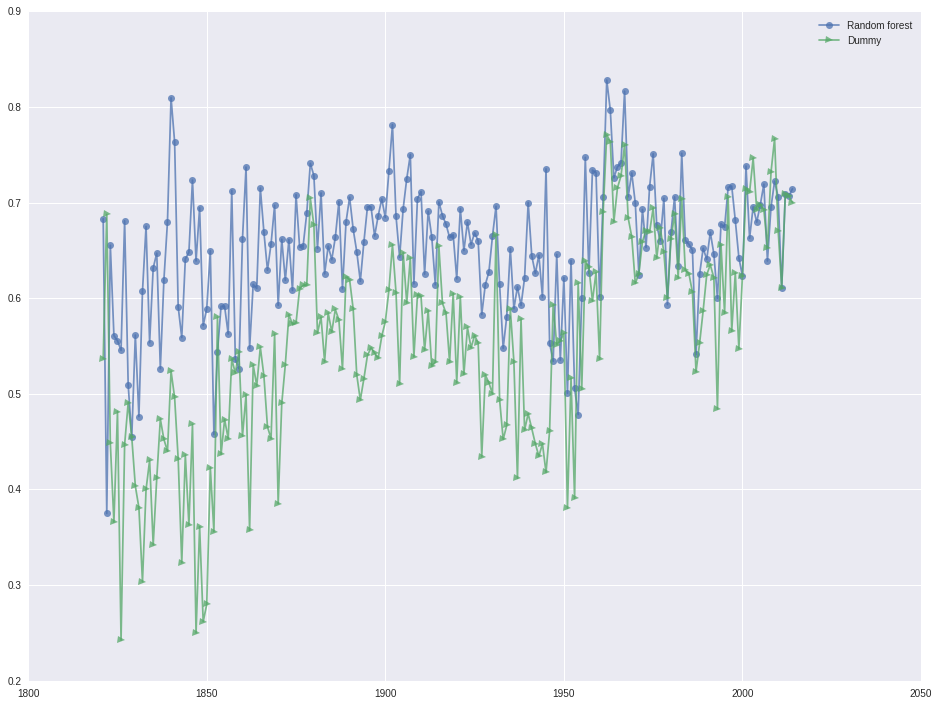

In [15]:
# Setup time series
rf_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

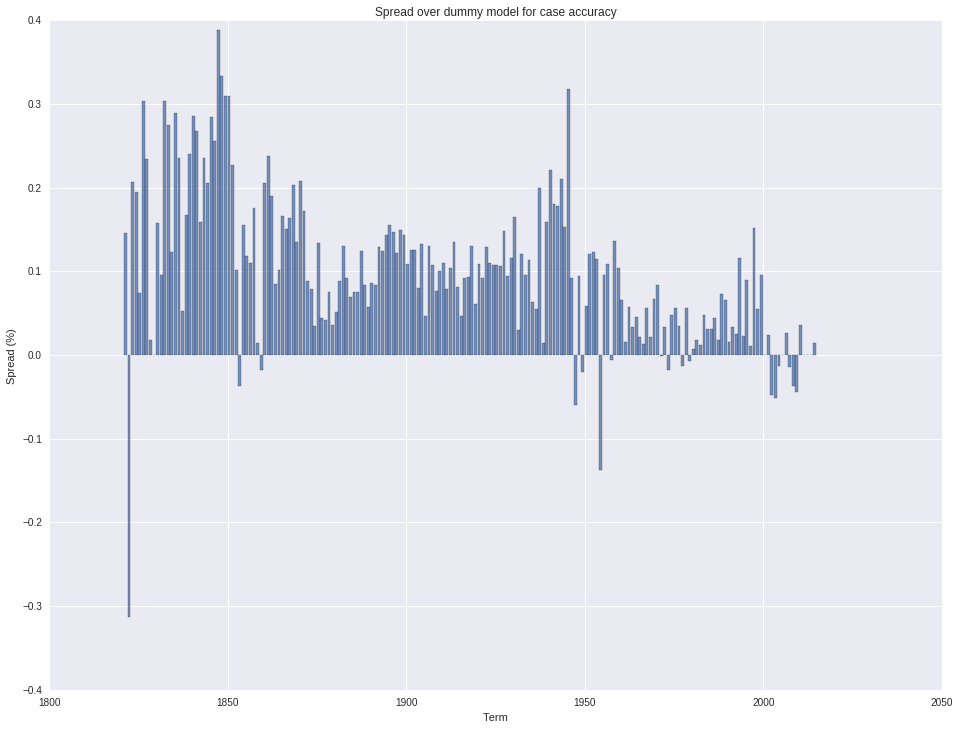

In [16]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for case accuracy")

/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.expanding_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).sum()
  from ipykernel import kernelapp as app


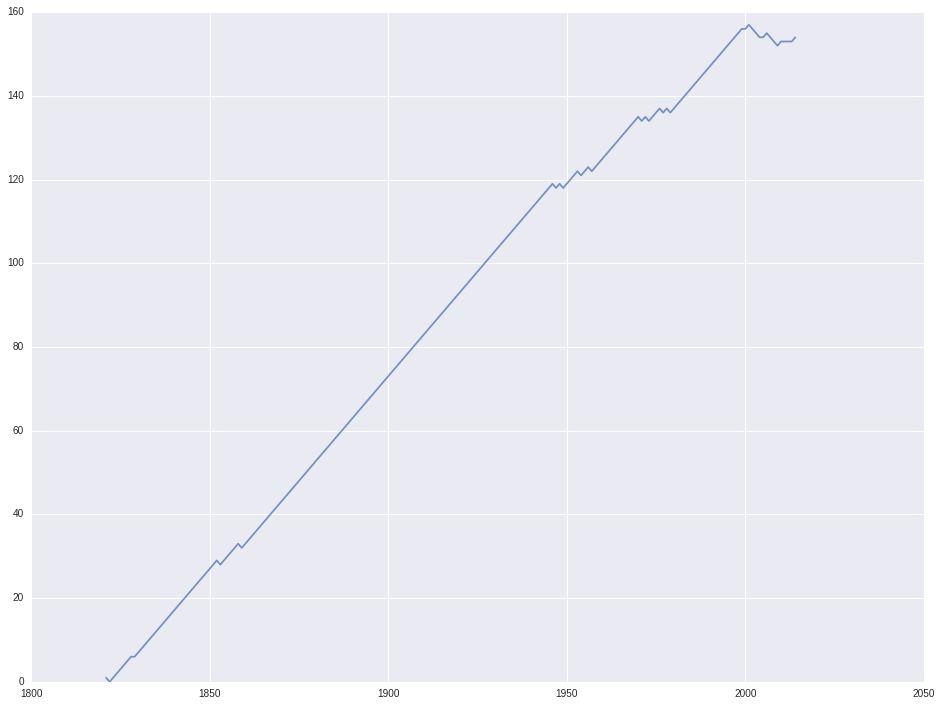

In [17]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)

In [18]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=14.992118789518559, pvalue=3.3711977846280216e-34)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=9.4744350977562188, pvalue=2.6820796838210296e-21)
Binomial:
1.95957811376e-210


In [21]:
raw_data.loc[raw_data.loc[:, "caseName"] == "MIRANDA v. ARIZONA", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,194698,194699,194700,194701,194702,194703,194704,194705,194706
caseName,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA
justiceName,JHarlan2,HLBlack,WODouglas,PStewart,WJBrennan,BRWhite,EWarren,TCClark,AFortas
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,1,1,0,1,0,1,0,1
rf_predicted,0,1,1,0,1,1,1,1,1
rf_predicted_score_affirm,0.542711,0.2,0.134286,0.551429,0.310476,0.435238,0.2,0.45619,0.299048
rf_predicted_score_reverse,0.426812,0.775238,0.848571,0.426667,0.66381,0.529524,0.72,0.519048,0.569524
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [22]:
# Output file data
file_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
raw_data.to_csv("../data/output/scdb_legacy_raw_data_most_frequent_{0}.csv".format(file_timestamp))
case_accuracy_data.to_csv("../data/output/scdb_legacy_case_data_most_frequent_{0}.csv".format(file_timestamp))